###### The probability of an eccentricity GIVEN that a planet is transiting (P(e|b)) and the probability of a longitude of periastron GIVEN that a planet is transiting (P(w|b)) are different than P(e) and P(w).

https://academic.oup.com/mnras/article/444/3/2263/1053015

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import matplotlib

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
from scipy.stats import rayleigh
import os

from pathlib import Path

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [3]:
def mode(dist):

    """Gets mode of a histogram.

    Parameters
    ----------
    dist: array
        Distribution

    Returns
    -------
    mode: float
        Mode
    """

    #n, bins = np.histogram(dist, bins=np.linspace(np.nanmin(dist), np.nanmax(dist), 100))
    n, bins = np.histogram(dist, bins=np.linspace(np.nanmin(dist), np.nanmax(dist), 500))
    mode = bins[np.nanargmax(n)]
    return mode

# UNIFORM DISTRIBUTION

In [38]:
distpath_uniform = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270/"

truee = []
truew = []
edist_uniform = []

for subdir, dirs, files in os.walk(distpath_uniform):
    try:
        trueparams = subdir.split("/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/hpgresults/uniform_dist/results_w_-90to270/e_",1)[1]
        truee.append(float(trueparams.split('_w_')[0]))
        truew.append(float(trueparams.split('_w_')[1]))
    except IndexError:
        continue
    for file in files:
        if 'distributions' in file:
            distpath = os.path.join(subdir, file)
            edist_uniform.append(np.genfromtxt(distpath, delimiter=','))
    
truee = np.array(truee)
truew = np.array(truew)
edist_uniform = np.array(edist_uniform)



In [39]:
fite = []
fitw = []
fitg = []

es_uniform = []
ws_uniform = []
gs_uniform = []


for i in range(len(edist_uniform)):
    
    es_uniform.append(edist_uniform[i][:,0])
    fite.append(ph.mode(edist_uniform[i][:,0]))
    
    ws_uniform.append(edist_uniform[i][:,1])
    fitw.append(ph.mode(edist_uniform[i][:,1]))
    
    gs_uniform.append(edist_uniform[i][:,2])
    fitg.append(ph.mode(edist_uniform[i][:,2]))
    
fite = np.array(fite)
es_uniform = np.array(es_uniform)

fitw = np.array(fitw)
ws_uniform = np.array(ws_uniform)

fitg = np.array(fitg)
gs_uniform = np.array(gs_uniform)

Text(0.5, 1.0, 'All E distributions (sample ~500)')

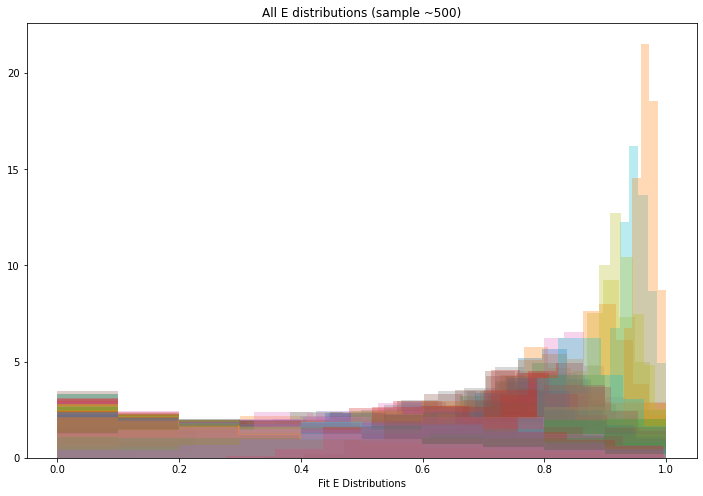

In [6]:
for i in range(len(es_uniform)):
    plt.hist(es_uniform[i], alpha=0.3, density=True, stacked=True);

plt.xlabel('Fit E Distributions')
plt.title('All E distributions (sample ~500)')

Text(0.5, 1.0, 'All w distributions (sample ~800)')

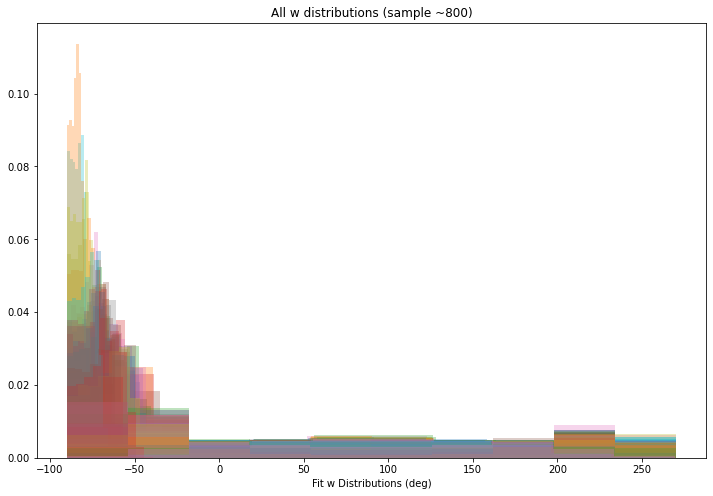

In [7]:
plt.cla()

for i in range(len(ws_uniform)):
    plt.hist(ws_uniform[i], alpha=0.3, density=True, stacked=True);

plt.xlabel('Fit w Distributions (deg)')
plt.title('All w distributions (sample ~800)')

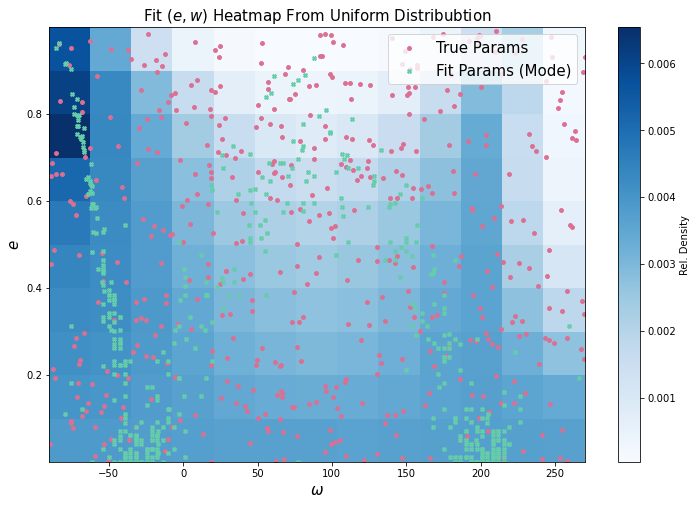

In [40]:
plt.cla()

fz = 15

plt.hist2d(ws_uniform.flatten(), es_uniform.flatten(), bins=[13,10], cmap='Blues', density=True);
plt.colorbar(label='Rel. Density')

plt.scatter(truew, truee, marker='o', s=15, c='palevioletred', label='True Params')
plt.scatter(fitw, fite, marker='X', s=15, c='mediumaquamarine', label='Fit Params (Mode)')

plt.legend(fontsize=fz)

plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From Uniform Distribubtion', fontsize=fz)

plt.savefig('Fit_EW_heatmap_uniform_new.png')

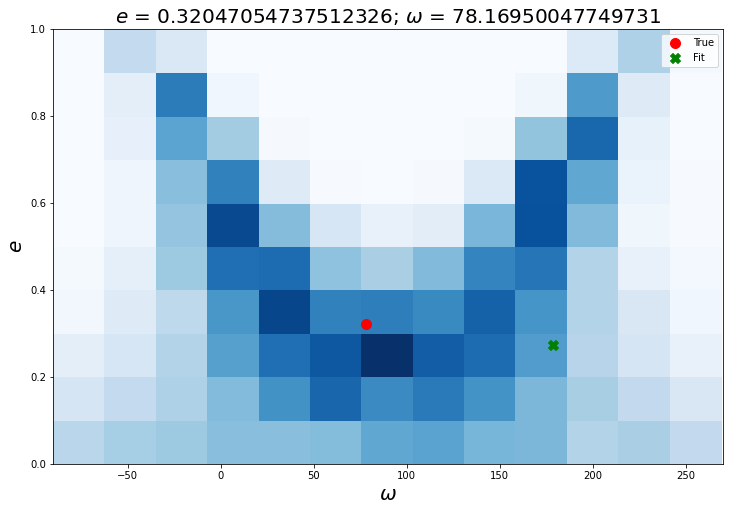

In [9]:
randint = int(np.random.randint(0, len(es_uniform), 1))


for i in range(len(es_uniform)):
    
    plt.cla()
    
    plt.hist2d(ws_uniform[i], es_uniform[i], cmap='Blues', bins=[13,10]);
    plt.scatter(truew[i], truee[i], c='r', s=100, label='True')
    plt.scatter(fitw[i], fite[i], c='g', marker='X', s=100, label='Fit')
    plt.xlim(-90, 270)
    plt.ylim(0, 1)

    plt.xlabel(r'$\omega$', fontsize=20)
    plt.ylabel('$e$', fontsize=20)
    plt.title('$e$ = ' + str(truee[i]) + '; $\omega$ = ' + str(truew[i]), fontsize=20)
    plt.legend()
    plt.savefig('all_new_heatmaps/e_' + str(truee[i]) + '_w_' + str(truew[i]) + 'singleheatmap.png')

In [53]:
wuniform = np.random.uniform(-90, 270, 50)


inds = []


for i in range(len(wuniform)):
    inds.append(int(np.argwhere(fitw == find_nearest(fitw, wuniform[i]))[0]))


euni = truee[inds].flatten()
wuni = truew[inds].flatten()

efuni = fite[inds].flatten()
wfuni = fitw[inds].flatten()
    
edistuni = np.array(es_uniform[inds]).flatten()

wdistuni = np.array(ws_uniform[inds]).flatten()

In [54]:
def deltallike(g, gerr, truee, truew, fite, fitw):
    
    model_fit = (1+e*np.sin(w*(np.pi/180.)))/np.sqrt(1-e**2)
    sigma2_fit = gerr ** 2
    loglike_fit = -0.5 * np.sum((g - model_fit) ** 2 / sigma2_fit + np.log(sigma2_fit))
    
    
    model_true = (1+truee*np.sin(truew*(np.pi/180.)))/np.sqrt(1-truee**2)
    sigma2_true = gerr ** 2
    loglike_true = -0.5 * np.sum((g - model_true) ** 2 / sigma2_true + np.log(sigma2_true))
    
    llike = np.abs(loglike_fit-loglike_true)
    return llike

In [55]:
llike = []

for i in range(len(truee)):

    g = ph.mode(gs_uniform[i])
    e = ph.mode(es_uniform[i])
    w = ph.mode(ws_uniform[i])
    
    gerr = np.nanstd(gs_uniform[i])
    
    llike.append(deltallike(g, gerr, truee[i], truew[i], e, w))
    
    
llike = np.array(llike)

llikeuni = llike[inds]

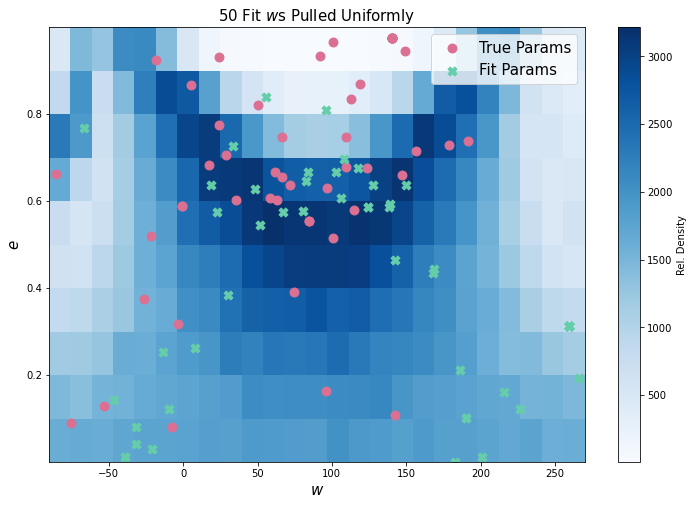

In [56]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues')#, norm=matplotlib.colors.LogNorm());
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')
plt.scatter(wuni, euni, marker='o', s=80, c='palevioletred', label='True Params')
plt.scatter(wfuni, efuni, marker='X', s=80, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled Uniformly', fontsize=fz)

plt.savefig('heatmap_truee_uniformwfit_50.png')

In [57]:
euni,wuni

(array([0.31573692, 0.93075218, 0.67560642, 0.51483084, 0.94390661,
        0.65581428, 0.67893909, 0.60111377, 0.96561711, 0.82147758,
        0.77493327, 0.97543572, 0.12766088, 0.97543572, 0.86715167,
        0.16165438, 0.57845053, 0.08868397, 0.68288549, 0.10675915,
        0.62857863, 0.7141334 , 0.66669791, 0.8331637 , 0.7288573 ,
        0.39000615, 0.58803185, 0.97543572, 0.7463901 , 0.97543572,
        0.74576875, 0.66076888, 0.97543572, 0.60125989, 0.55265842,
        0.51897749, 0.60651713, 0.37327833, 0.70554405, 0.55265842,
        0.58803185, 0.63685528, 0.97543572, 0.86847967, 0.93370961,
        0.07944152, 0.6606012 , 0.97543572, 0.73676826, 0.92432875]),
 array([ -3.44131704,  24.16542819, 123.39742968, 100.48103722,
        148.98963844,  66.39591601, 109.7585292 ,  63.09124981,
        100.85469462,  50.21968045,  24.2619451 , 140.19983683,
        -53.06662081, 140.19983683,   5.52971566,  95.93862601,
        114.90188018, -75.30975743,  17.32975001, 142.70016334

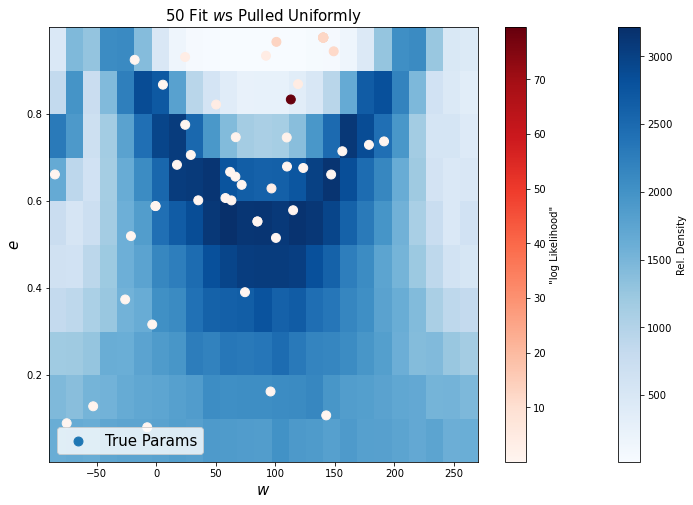

In [58]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues')#, norm=matplotlib.colors.LogNorm());
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')


plt.scatter(wuni, euni, marker='o', s=80, c=llikeuni, label='True Params', cmap='Reds')#, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='"log Likelihood"')

#plt.scatter(wfuni, efuni, marker='X', s=80, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled Uniformly', fontsize=fz)

plt.savefig('heatmap_truee_uniformwfit50_llike_new.png')

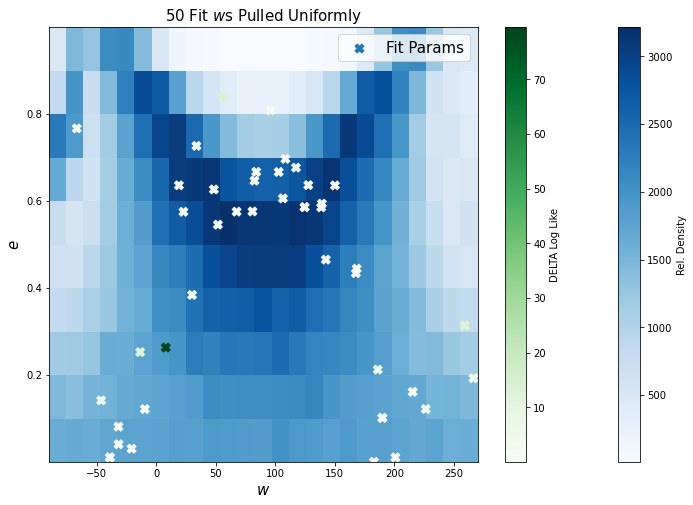

In [59]:
plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues')#, norm=matplotlib.colors.LogNorm());
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')


plt.scatter(wfuni, efuni, marker='X', s=80, c=llikeuni, label='Fit Params', cmap='Greens')#, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DELTA Log Like')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled Uniformly', fontsize=fz)

plt.savefig('heatmap_truee_uniformwfit50_lfitslike_new.png')

<ipython-input-62-0df879438d1b>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  cmap.set_bad(color='white')


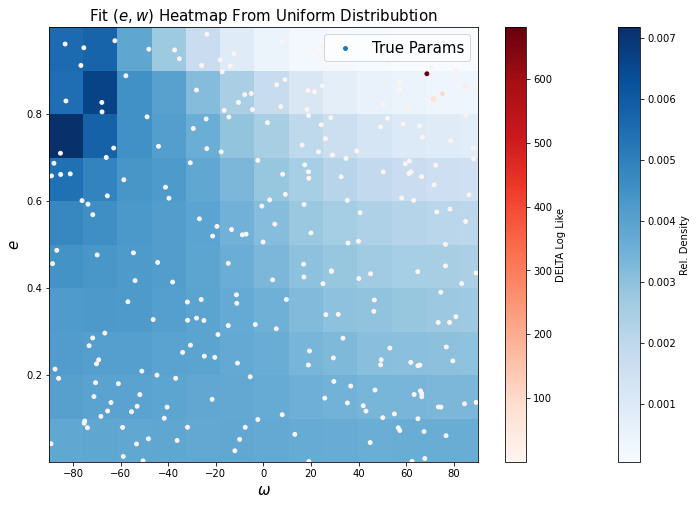

In [62]:
plt.cla()

fz = 15

cmap = plt.cm.Reds
cmap.set_bad(color='white')

plt.hist2d(ws_uniform.flatten(), es_uniform.flatten(), bins=[25,10], cmap='Blues', density=True)#, norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

plt.scatter(truew, truee, marker='o', s=15, c=llike, label='True Params', cmap=cmap)#, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DELTA Log Like')
#plt.scatter(fitw, fite, marker='x', s=15, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From Uniform Distribubtion', fontsize=fz)

plt.savefig('heatmap_llike_colorbar.png')

<ipython-input-63-d7d26c93dd7b>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greens"))
  cmap.set_bad(color='white')


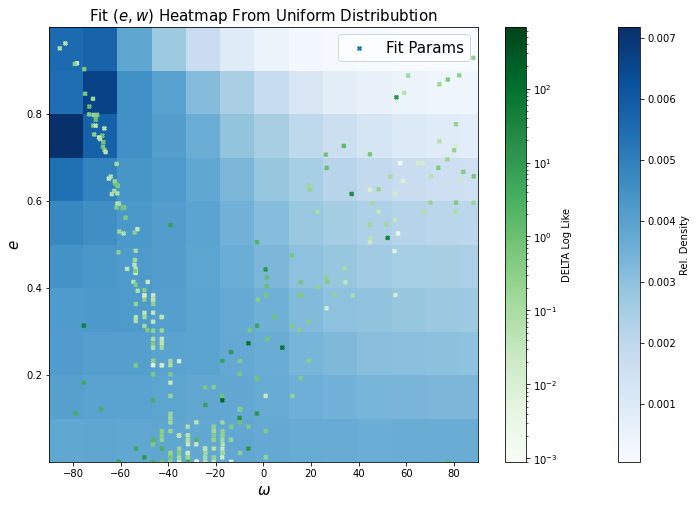

In [63]:
plt.cla()

fz = 15

cmap = plt.cm.Greens
cmap.set_bad(color='white')

plt.hist2d(ws_uniform.flatten(), es_uniform.flatten(), bins=[25,10], cmap='Blues', density=True)#, norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

#plt.scatter(truew, truee, marker='o', s=15, c=llike, label='True Params', cmap='Reds', norm=matplotlib.colors.LogNorm())
plt.scatter(fitw, fite, marker='X', s=15, c=llike, label='Fit Params', cmap=cmap, norm=matplotlib.colors.LogNorm())
plt.colorbar(label='DELTA Log Like')
plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From Uniform Distribubtion', fontsize=fz)

plt.savefig('heatmap_llike_colorbar_fit.png')

Text(0.5, 1.0, 'e distribution')

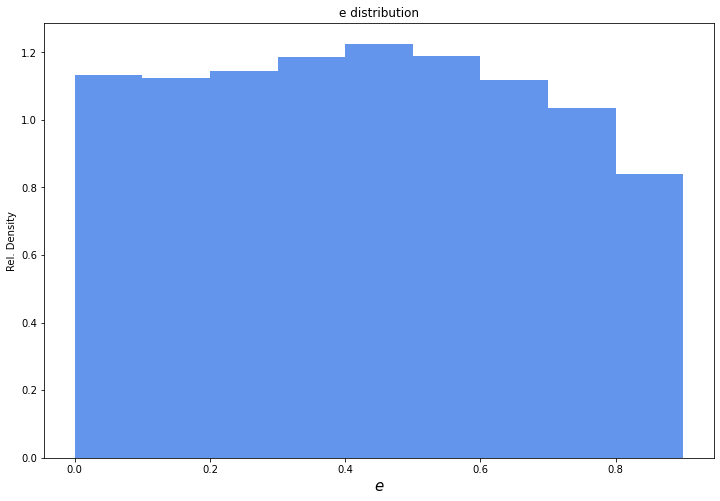

In [19]:
plt.hist(edistuni, color='cornflowerblue', bins=np.arange(0, 1, 0.1), density=True, stacked=True)
plt.xlabel('$e$', fontsize=fz)
plt.ylabel('Rel. Density')
plt.title('e distribution')

# GAUSSIAN DISTRIBUTION

In [20]:
# e_rand = np.random.normal(0.4, 0.1, size=n)
# w_rand = np.random.normal(0.0, 45.0, size=n)

In [21]:
trueew_gaussian = pd.read_csv('/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/gaussian/fitew.txt', index_col=False)

distpath_gaussian = "/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/plots_hpg/gaussian/edists/"

paths = sorted(Path(distpath_gaussian).iterdir(), key=os.path.getmtime)
paths.reverse()

edist_gaussian = []

for file in paths:
    fname = os.path.join(distpath_gaussian, file)
    try:
        edist_gaussian.append(np.genfromtxt(fname, delimiter=','))
    except UnicodeDecodeError:
        pass

es_gaussian = []
ws_gaussian = []
gs_gaussian = []

for i in range(len(edist_gaussian)):

    es_gaussian.append(edist_gaussian[i][:,0])
    ws_gaussian.append(edist_gaussian[i][:,1])
    gs_gaussian.append(edist_gaussian[i][:,2])

es_gaussian = np.array(es_gaussian)

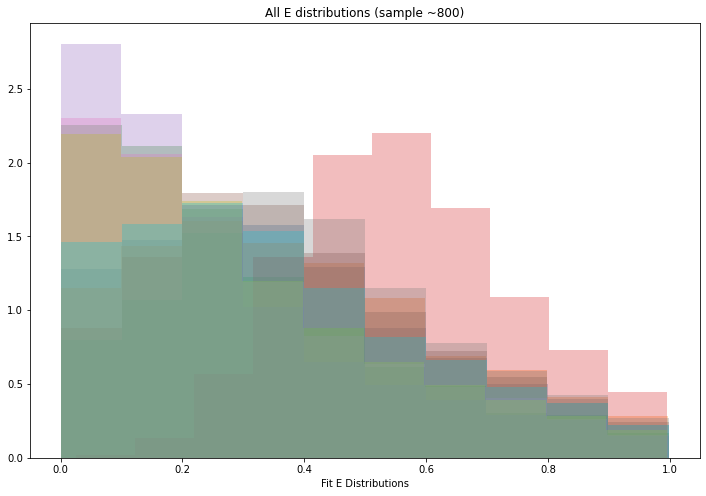

In [22]:
fite = []

plt.cla()

for i in range(len(es_gaussian)):
    fite.append(mode(es_gaussian[i]))
    plt.hist(es_gaussian[i], alpha=0.3, density=True, stacked=True);
    
fite = np.array(fite)
plt.xlabel('Fit E Distributions')
plt.title('All E distributions (sample ~800)')

ws_gaussian = np.array(ws_gaussian)

Text(0.5, 1.0, 'All w distributions (sample ~800)')

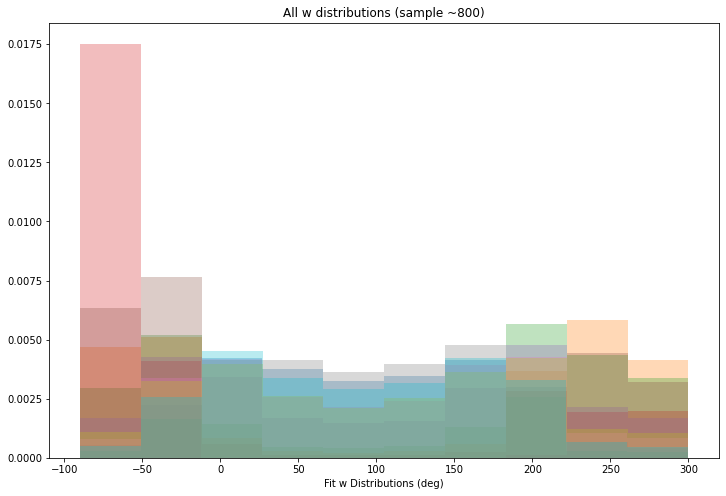

In [23]:
fitw = []

plt.cla()

for i in range(len(ws_gaussian)):
    fitw.append(mode(ws_gaussian[i]))
    plt.hist(ws_gaussian[i], alpha=0.3, density=True, stacked=True);
    

fitw = np.array(fitw)
plt.xlabel('Fit w Distributions (deg)')
plt.title('All w distributions (sample ~800)')

In [24]:
truew = np.array(trueew_gaussian['truew'])
truee = np.array(trueew_gaussian['truee'])

len(truee)

10

In [25]:
for i in range(len(fitw)):
    if fitw[i] > 90:
        fitw[i] = fitw[i]-180

<ipython-input-26-541bb83adc7d>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Blues"))
  cmap.set_bad(color='white')


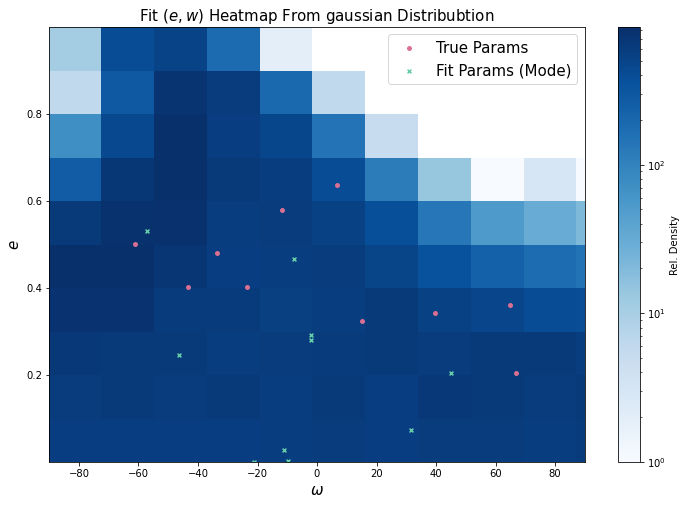

In [26]:
plt.cla()

fz = 15

cmap = plt.cm.Blues
cmap.set_bad(color='white')

plt.hist2d(ws_gaussian.flatten(), es_gaussian.flatten(), bins=[22,10], cmap=cmap, norm=matplotlib.colors.LogNorm());
plt.colorbar(label='Rel. Density')

plt.scatter(truew, truee, marker='o', s=15, c='palevioletred', label='True Params')
plt.scatter(fitw, fite, marker='x', s=15, c='mediumaquamarine', label='Fit Params (Mode)')

plt.legend(fontsize=fz)

plt.xlim(-90, 90)
plt.xlabel('$\omega$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('Fit $(e,w)$ Heatmap From gaussian Distribubtion', fontsize=fz)

plt.savefig('Fit_EW_heatmap_gaussian.png')

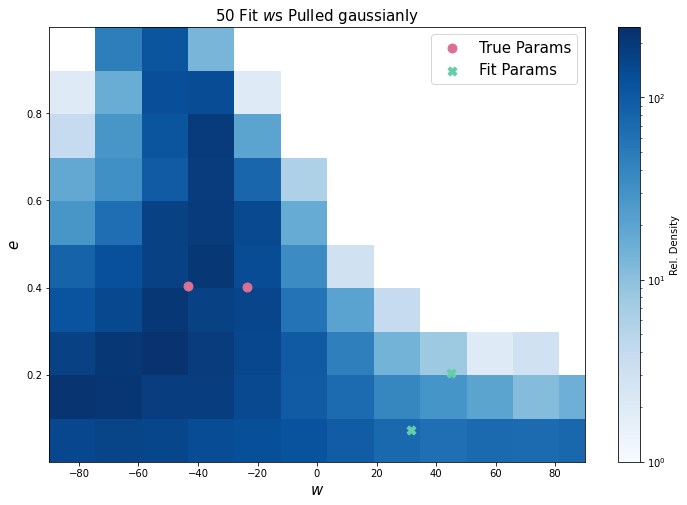

In [27]:
wgaussian = np.random.uniform(-90, 90, 2)


inds = []

for i in range(len(wgaussian)):
    inds.append(int(np.argwhere(fitw == find_nearest(fitw, wgaussian[i]))[0]))


euni = truee[inds].flatten()
wuni = truew[inds].flatten()

efuni = fite[inds].flatten()
wfuni = fitw[inds].flatten()
    
edistuni = np.array(es_gaussian[inds]).flatten()

wdistuni = np.array(ws_gaussian[inds]).flatten()

llike = []

for i in range(len(fite)):

    counts, wbins, ebins = np.histogram2d(ws_gaussian[i], es_gaussian[i], bins=15);
    
    llike.append(counts[np.digitize(truew[i], wbins)-1, np.digitize(truee[i], ebins)-1])
    
llike = np.array(llike)

llikeuni = llike[inds]

plt.cla()

fz = 15

plt.hist2d(wdistuni, edistuni, bins=[25,10], cmap='Blues', norm=matplotlib.colors.LogNorm());
plt.xlim(-90, 90)
#plt.clim(vmax=4000.0)
plt.colorbar(label='Rel. Density')
plt.scatter(wuni, euni, marker='o', s=80, c='palevioletred', label='True Params')
plt.scatter(wfuni, efuni, marker='X', s=80, c='mediumaquamarine', label='Fit Params')

plt.legend(fontsize=fz)

plt.xlabel('$w$', fontsize=fz)
plt.ylabel('$e$', fontsize=fz)
plt.title('50 Fit $w$s Pulled gaussianly', fontsize=fz)

plt.savefig('heatmap_truee_gaussianwfit_50.png')